# Helicopter fuel consumption

This notebook is meant to explain the behavior of fuel consumption curves, for e.g. see figures below (taken from Principles of Helicopter Aerodynamics by JG Leishman), following a trend that seems to stand in contrast with the required power curves. 


<table><tr>
<td> <img src="../figures/Leishman_516.png" alt="Drawing" style="width: 350px;"/> </td>
<td> <img src="../figures/Leishman_512.png" alt="Drawing" style="width: 350px;"/> </td>
</tr></table>

## Importing standard libraries

In [8]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter    
import numpy as np
import os
import imageio
from IPython.display import Image
%matplotlib inline

### Defining quantities corresponding to a sample helicopter (SI units)


In [9]:
Vinf_max = 100    #max. forward speed
k = 1.15          #kappa
W = 3400*9.8
d_area = 1.1      #drag area
R = 5.5
Vtip = 210
sigma = 0.08
Cd0 = 0.01

### Defining quantities corresponding to the powerplant

In [10]:
p0 = 101325       #std atmospheric pressure
T0 = 288          #std atmposheric temp
R_gas = 287.04    #gas constant
Ae = 40
Be = 0.25
h = np.array([-2000,0,2000,4000,6000])
N_eng = 4         #no of engines

### Relevant derived quantities

In [11]:
A = np.pi*R**2
Vinf = np.linspace(0,Vinf_max,41)
mu = Vinf/Vtip


### Functions to calculate power and atmospheric conditions

In [12]:
def get_vi(Vinf,T=W,alt=0):    
    
    vh = (T/(2*get_rho(alt=alt)*A))**0.5    
    vi_arr = (-0.5*Vinf**2 + (vh**4 + 0.25*Vinf**4)**0.5)**0.5
        
    return vi_arr

def get_Pi_id(Vinf,T=W,alt=0):
    
    return T*get_vi(Vinf,alt=alt)

def get_P0(Vinf,alt=0):
    
    return 0.125*get_rho(alt=alt)*A*(Vtip**3)*sigma*Cd0*(1+4.65*((Vinf/Vtip)**2))
 
def get_Pp(Vinf,alt=0):
    
    return 0.5*get_rho(alt=alt)*(Vinf**3)*d_area

def get_P(Vinf,alt=0):   #default result at 0 altitude

    Pi = k*get_Pi_id(Vinf, alt=alt)
    P0 = get_P0(Vinf, alt=alt)
    Pp = get_Pp(Vinf, alt=alt) 
    
    return Pi+P0+Pp

def get_rho(alt=0):
    
    return get_p(alt)/(R_gas*get_T(alt))

def get_p(alt):
    
    return p0*(1-0.0065*alt/T0)**5.2561

def get_T(alt):
    
    return T0*(1-0.0065*alt/T0)

### Plotting and verifying the power curves

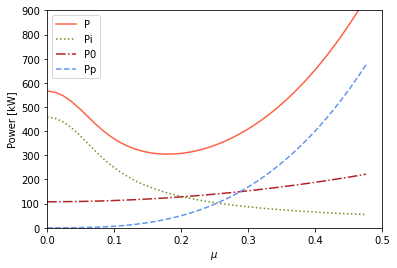

In [13]:
Pi = k*get_Pi_id(Vinf)
P0 = get_P0(Vinf)
Pp = get_Pp(Vinf)  
P = get_P(Vinf)

color_scheme = ["red","lime","deepskyblue","black","grey"] #same size as h

plt.figure()
plt.plot(mu, P/1000, color="tomato", linestyle="-", label="P")
plt.plot(mu, Pi/1000, color="olivedrab", linestyle=":", label="Pi")
plt.plot(mu, P0/1000, color="firebrick", linestyle="-.", label="P0")
plt.plot(mu, Pp/1000, color="cornflowerblue", linestyle="--", label="Pp")

plt.ylim((0, 900))
plt.xlim((0, 0.5))
plt.ylabel(r"Power [kW]")
plt.xlabel(r"$\mu$")
plt.legend()



### Additional functions for creating W_fuel and Power vs altitude plots

In [14]:
p = get_p(h)
T = get_T(h)
delta = p/p0
theta = T/T0

def fig_axes():
    fig = plt.figure(figsize=(10,5))
    gs = gridspec.GridSpec(1, 2, figure=fig)
    ax_wfuel = fig.add_subplot(gs[0])
    ax_p_alt = fig.add_subplot(gs[1])
    
    return fig, ax_wfuel, ax_p_alt

def plot_wf_p(n_eng,ax_wfuel,ax_p_alt,for_gif=False):
    Wfuel_dot = np.zeros((len(Vinf),len(h)))
    P_alt = np.zeros((len(Vinf),len(h)))
    for i,(alt,c) in enumerate(zip(h,color_scheme)):    
        P_alt[:,i] = get_P(Vinf,alt=alt)
        Wfuel_dot[:,i] = n_eng*(Ae*delta[i]*(theta[i]**0.5) + Be*(P_alt[:,i]/1000)*(1/n_eng))
    
        ax_wfuel.plot(mu, Wfuel_dot[:,i], color=c)
        ax_wfuel.set_title(f'N_eng = {n_eng}')

        labl=None
        if for_gif:        #sets legend in every plot, necessary for gif
            labl=f"h={alt} m"
        elif n_eng==N_eng:       #to avoid repeating labels in legend
                labl=f"h={alt} m"                  
        ax_p_alt.plot(mu, P_alt[:,i]/1000, color=c, label=labl)
        
  
def fig_details(ax_wfuel,ax_p_alt):
    ax_wfuel.set_ylabel(r"$\dot{W}_{fuel}$ [kg/h]")
    ax_wfuel.set_xlabel(r"$\mu$")
    ax_p_alt.set_ylabel(r"Power [kW]")
    ax_p_alt.set_xlabel(r"$\mu$")
    ax_wfuel.set_ylim(100,450)
    ax_p_alt.set_ylim(0,900)
    ax_p_alt.legend()

### Plotting and verifying the W_fuel and Power vs altitude curves

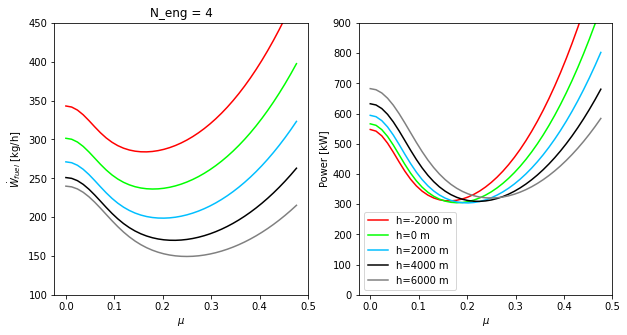

In [15]:
Fig, Ax_wfuel, Ax_p_alt = fig_axes()
plot_wf_p(N_eng,Ax_wfuel,Ax_p_alt)  
fig_details(Ax_wfuel, Ax_p_alt)

### Creating a gif to see the effect of 'N_eng' on the 'W_fuel' curves

In [20]:
filenames = []
for n_eng in range(1,N_eng+1,1):
    if N_eng==1:
        raise Exception(f"N_eng is currently {N_eng}. It should be greater than 1 to create a gif")
    Fig, Ax_wfuel, Ax_p_alt = fig_axes()
    plot_wf_p(n_eng,Ax_wfuel,Ax_p_alt,for_gif=True)
    fig_details(Ax_wfuel, Ax_p_alt)
    # create file name and append it to a list
    filename = f'N_eng={n_eng}.jpg'
    filenames.append(filename)
    
    # save frame
    Fig.savefig(filename)
    plt.close()

# build gif
with imageio.get_writer('mygif.gif', mode='i', fps=2) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)
#display gif
#from IPython.display import Image
#Image(filename="mygif.gif")




In [21]:
from IPython.display import HTML
display(HTML('<img src="mygif.gif">'))
